# Introduction to Artificial Neural Networks

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

## Preamble

This notebook is an introduction to the fundamental model/paradigm behind deep learning: the artificial neural network

We're going to write code to build an ANN from scratch, then we're going to build a similar ANN using tensorflow. You'll see that the tensorflow implementation is much faster and also simpler to program

We'll start with a 15 minute video

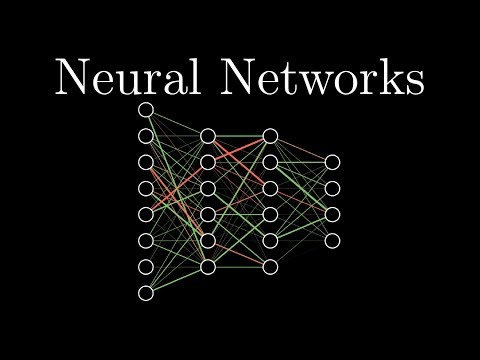

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('aircAruvnKk')

Artificial neural networks (ANNs) are software implementations of the neuronal structure of our brains.  

* The brain contains neurons which are like organic switches.  These can change their output state depending on the strength of their electrical or chemical input.  The neural network in a person’s brain is a hugely interconnected network of neurons, where the output of any given neuron may be the input to thousands of other neurons.  

* Learning occurs by repeatedly activating certain neural connections over others, and this reinforces those connections.  This makes them more likely to produce a desired outcome given a specified input.  

* This learning involves feedback – when the desired outcome occurs, the neural connections causing that outcome become strengthened.

Artificial neural networks attempt to simplify and mimic this brain behaviour. In a supervised ANN, the network is trained by providing matched input and output data samples, with the intention of getting the ANN to provide a desired output for a given input. 

### ANN components

1. Architecture: describes the layers and structure of the connections between them
2. Activation function: defines the output of a node given an input or set of inputs
3. Learning algorithm that finds the optimal model parameters

### Features

1. Work well only for very large datasets (we're going to train on a small dataset)
2. Notoriously slow to train - need GPUs (we're going to use a single CPU)

## Objective

We're going to construct an ANN to recognize image classes. First we'll do it without tensorflow, then we'll do it with tensorflow. This will hopefully demonstrate why tensorflow is such a popular framework for ANN analysis

## Constructing a multi-class neural network classifier

First, load the usual libraries

In [3]:
import matplotlib.pyplot as plt 
import numpy as np
from skimage.transform import resize
from imageio import imread
from skimage import color

In [4]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)
root = 'esipfed/cdi-workshop'

### Preparing a data set

Let's take a look at some data. We'll limit this to 12 categories of images

In [5]:
cats = [f for f in fs.ls(root+'/imrecog_data/NWPU-RESISC45/train')][::4]
N = len(cats)
cats

['esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/airplane',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/beach',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/circular_farmland',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/desert',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/ground_track_field',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/island',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/mobile_home_park',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/parking_lot',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/river',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/ship',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/storage_tank',
 'esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/wetland']

In [6]:
N

12

Let's specify the number of images per category we want to train with, and the size of the images we want to train with

In [7]:
number_per_cat = 100 ##500
size = 96

Here we will read each image into a list, convert to greyscale, resize it, and keep track of its label 

In [8]:
images = []
labels = []
counter = 0
for cat in cats:
    print(cat)
    files = [f for f in fs.ls(cat) if f.endswith('.jpg')][:number_per_cat]
    for file in files:
        with fs.open(file, 'rb') as f:
            #images.append(resize(color.rgb2gray(imread(f, 'jpg')), (size, size)).flatten()) ## for working with greyscale imagery
            images.append(resize(imread(f, 'jpg'), (size, size)).flatten())
            labels.append(counter)
    counter += 1            

esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/airplane


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/beach
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/circular_farmland
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/desert
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/ground_track_field
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/island
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/mobile_home_park
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/parking_lot
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/river
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/ship
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/storage_tank
esipfed/cdi-workshop/imrecog_data/NWPU-RESISC45/train/wetland


In [9]:
images = np.asarray(images)
print(images.shape)

(1200, 27648)


We can view an individual image to check it

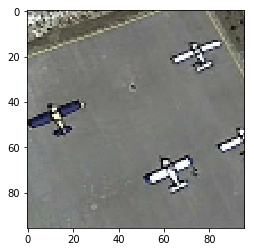

In [10]:
##plt.imshow(images[0].reshape(size,size), cmap='gray')
plt.imshow(images[0].reshape(size,size,3))

It’s standard practice to scale the input data so that it all fits mostly between either 0 to 1 or with a small range centred around 0 i.e. -1 to 1.  

Why?  It can help the convergence of the neural network and is especially important if we are combining different data types.

The scikit learn standard scaler by default normalises the data by subtracting the mean and dividing by the standard deviation. 

In [11]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler()
X = X_scale.fit_transform(images)

In [12]:
np.shape(X)

(1200, 27648)

To make sure that we are not creating models which are too complex, it is common practice to split the dataset into a training set and a test set. The training set is, obviously, the data that the model will be trained on, and the test set is the data that the model will be tested on after it has been trained. The amount of training data is always more numerous than the testing data, and is usually between 60-80% of the total dataset.

In [13]:
from sklearn.model_selection import train_test_split
y = labels 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [14]:
np.shape(X_train)

(900, 27648)

### Setting up the network

Neural network architecture would be to have an output layer of 10 nodes, with each of these nodes representing a label from 0 to 9. 

We want to train the network so that when, say, an image of the digit “1” is presented to the neural network, the node in the output layer representing 1 has the highest value. 

like this: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]. 

In machine learning, this is called *one-hot* encoding

In [15]:
def convert_y_to_vect(y, N):
    y_vect = np.zeros((len(y), N))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect
y_v_train = convert_y_to_vect(y_train, N)
y_v_test = convert_y_to_vect(y_test, N)
y_train[0], y_v_train[0]

(10, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

The next step is to specify the structure of the neural network. 

For the input layer, we know we need MxN nodes to cover the pixels in the image. 

We need 12 output layer nodes to predict the 12 classes. 

We’ll also need a hidden layer in our network to allow for the complexity of the task. Usually, the number of hidden layer nodes is somewhere between the number of input layers and the number of output layers. Let’s define a simple Python list that designates the structure of our network:

In [16]:
num_neurons = 5

##nn_structure = [size**2, num_neurons, N]  ## for working with greyscale imagery

nn_structure = [3*size**2, num_neurons, N]

### Activation function

![](figs/Picture13.png)

The biological neuron is simulated in an ANN by an activation function. In classification tasks this activation function has to have a “switch on” characteristic – in other words, once the input is greater than a certain value, the output should change state i.e. from 0 to 1, from -1 to 1 or from 0 to >0. 

This simulates the “turning on” of a biological neuron. A common activation function that is used is the sigmoid function:

$f(z)=\frac{1}{1+\exp(−z)}$


Which looks like this:

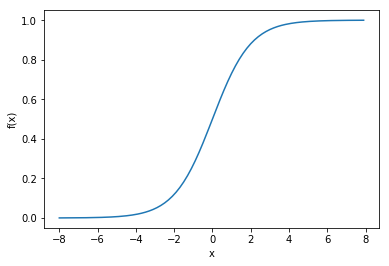

In [17]:
x = np.arange(-8, 8, 0.1)
f = 1 / (1 + np.exp(-x))
plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

 the function is “activated” i.e. it moves from 0 to 1 when the input x is greater than a certain value. The sigmoid function isn’t a step function however, the edge is “soft”, and the output doesn’t change instantaneously. 

biological neurons are connected hierarchical networks, with the outputs of some neurons being the inputs to others. We can represent these networks as connected layers of nodes. Each node takes multiple weighted inputs, applies the activation function to the summation of these inputs, and in doing so generates an output.

![](figs/Picture14.png)

![](figs/Picture15.png)

### Network Structure

The most common simple neural network structure consists of an input layer, a hidden layer and an output layer.  An example of such a structure can be seen below:

![Three layer neural network](http://adventuresinmachinelearning.com/wp-content/uploads/2017/03/Three-layer-network-300x158.png)

Layer 1 represents the input layer, where the external input data enters the network. Layer 2 is called the hidden layer as this layer is not part of the input or output. Note: neural networks can have many hidden layers, but in this case for simplicity I have just included one. Finally, Layer 3 is the output layer. 

You can observe the many connections between the layers. Each of these connections will have an associated weight.

### Weights

The ANN is a hierarchical network of connected layers of nodes. Each node takes multiple weighted inputs, applies the activation function to the summation of these inputs, and in doing so generates an output. 

The *weights* are the variables that are changed during the learning process, and, along with the input, determine the output of the node.

Below is an illustration of how changing weights modifies the activation function:

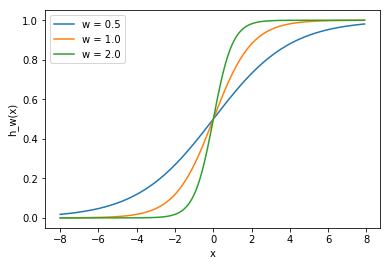

In [18]:
w1 = 0.5
w2 = 1.0
w3 = 2.0
l1 = 'w = 0.5'
l2 = 'w = 1.0'
l3 = 'w = 2.0'
for wght, lab in [(w1, l1), (w2, l2), (w3, l3)]:
    f = 1 / (1 + np.exp(-x*wght))
    plt.plot(x, f, label=lab)
plt.xlabel('x')
plt.ylabel('h_w(x)')
plt.legend(loc=2)
plt.show()

Here we can see that changing the weight changes the slope of the output of the sigmoid activation function, which is obviously useful if we want to model different strengths of relationships between the input and output variables.  The activation function can also be modified using biases:

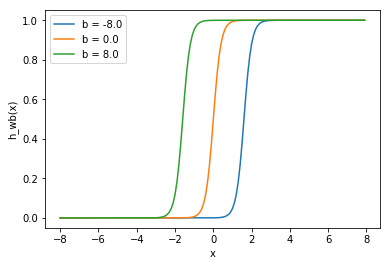

In [19]:
wght = 5.0
b1 = -8.0
b2 = 0.0
b3 = 8.0
l1 = 'b = -8.0'
l2 = 'b = 0.0'
l3 = 'b = 8.0'
for bias, lab in [(b1, l1), (b2, l2), (b3, l3)]:
    f = 1 / (1 + np.exp(-(x*wght+bias)))
    plt.plot(x, f, label=lab)
plt.xlabel('x')
plt.ylabel('h_wb(x)')
plt.legend(loc=2)
plt.show()

By varying the bias “weight” b, you can change when the node activates. Therefore, by adding a bias term, you can make the node simulate a generic if function, i.e. if (x > z) then 1 else 0.

So the first step is to initialise the weights for each layer. 

To make it easy to organise the various layers, we’ll use Python dictionary objects (initialised by {}). Finally, the weights have to be initialised with random values – this is to ensure that the neural network will converge correctly during training. We use the numpy library random_sample function to do this. 

The weight initialisation code is shown below:

In [20]:
import numpy.random as r
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

setup the sigmoid function and its derivative:

In [21]:
def f(x):
    return 1 / (1 + np.exp(-x))
def f_deriv(x):
    return f(x) * (1 - f(x))

### Perceptron to Neural Network

Perceptron:
    
![](figs/Picture16.png)


Multi-output perceptron:
    
![](figs/Picture17.png)


Single-layer neural network:
    
![](figs/Picture18.png)

### Training

Training constitutes setting of the values of the weights which link the layers in the network. In supervised learning, the idea is to reduce the error between the input and the desired output.

The idea of supervised learning is to provide many input-output pairs of known data and vary the weights based on these samples so that the error expression is minimised.

How do we know how to vary the weights, given an error in the output of the network? This is where the concept of gradient descent comes in handy. 

In [22]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

The first step is to perform a feed forward pass through the network.

This is how you calculate the output of the network when the input and the weights are known.

This function takes as input the number of layers in the neural network, the x input array/vector, then Python tuples or lists of the weights and bias weights of the network, with each element in the tuple/list representing a layer l in the network.  

In [23]:
def feed_forward(x, W, b):
    h = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        # if it is the first layer, then the input into the weights is x, otherwise, 
        # it is the output from the last layer
        if l == 1:
            node_in = x
        else:
            node_in = h[l]
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)  
        h[l+1] = f(z[l+1]) # h^(l) = f(z^(l)) 
    return h, z

### Training the network

We're not setting a termination of the gradient descent process based on some change or precision of the cost function. 

Rather, we are just running it for a set number of iterations and we’ll monitor how the average cost function changes as we progress through the training (```avg_cost_func``` list in the below code). 

In each iteration of the gradient descent, we cycle through each training sample ```(range(len(y))``` and perform the feed forward pass and then the backpropagation. 

### Backpropagation

The backpropagation step is an iteration through the layers starting at the output layer and working backwards – ```range(len(nn_structure), 0, -1)```. 

We calculate the average cost, which we are tracking during the training, at the output layer (```l == len(nn_structure)```). 

We also update the mean accumulation values, designated as tri_W and tri_b, for every layer apart from the output layer (there are no weights connecting the output layer to any further layer)

Finally, after we have looped through all the training samples, accumulating the tri_W and tri_b values, we perform a gradient descent step change in the weight and bias values

After the process is completed, we return the trained weight and bias values, along with our tracked average cost for each iteration.

In [24]:
def calculate_out_layer_delta(y, h_out, z_out):
    return -(y-h_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [25]:
def train_nn(nn_structure, X, y, iter_num=600, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%50 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(len(y)):
            delta = {}
            # perform the feed forward pass and return the stored h and z values, to be used in the
            # gradient descent step
            h, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) 
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

In [26]:
alpha = 0.1 #learning rate
iter_num = 800 #number of iterations

While we train the network, let's watch a video that explains what it is doing!

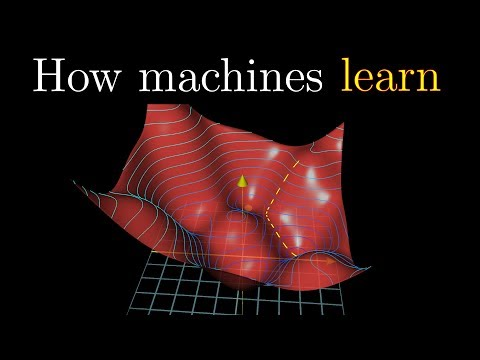

In [27]:
YouTubeVideo('IHZwWFHWa-w')

![](figs/waiting.jpg)

Let's run the function

In [28]:
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, iter_num, alpha)

Starting gradient descent for 800 iterations
Iteration 0 of 800


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Iteration 50 of 800
Iteration 100 of 800
Iteration 150 of 800
Iteration 200 of 800
Iteration 250 of 800
Iteration 300 of 800
Iteration 350 of 800
Iteration 400 of 800
Iteration 450 of 800
Iteration 500 of 800
Iteration 550 of 800
Iteration 600 of 800
Iteration 650 of 800
Iteration 700 of 800
Iteration 750 of 800


Now we can have a look at how the average cost function decreased as we went through the gradient descent iterations of the training, slowly converging on a minimum in the function:

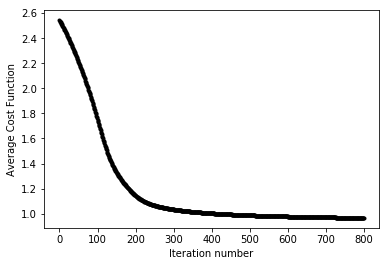

In [29]:
plt.plot(avg_cost_func, 'k.')
plt.ylabel('Average Cost Function')
plt.xlabel('Iteration number')
plt.show()

our average cost function value has started to “plateau” and therefore any further increases in the number of iterations isn’t likely to improve the performance of the network by much.

### Evaluating the network

Given a test input, we need to find what the output of our neural network is – we do that by simply performing a feed forward pass through the network using our trained weight and bias values. 

As discussed previously, we assess the prediction of the output layer by taking the node with the maximum output as the predicted digit. We can use the numpy.argmax function for this, which returns the index of the array value with the highest value:

In [30]:
def predict_y(W, b, X, n_layers):
    m = X.shape[0]
    y = np.zeros((m,))
    for i in range(m):
        h, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(h[n_layers])
    return y

Let's load a convenience function from scikit-learn to assess the overall accuracy

In [31]:
from sklearn.metrics import accuracy_score
y_pred = predict_y(W, b, X_test, 3)
accuracy_score(y_test, y_pred)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.16

And we can compute and visualize the confusion matrix like we did in a previous exercise

In [32]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.75)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.axis('tight')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


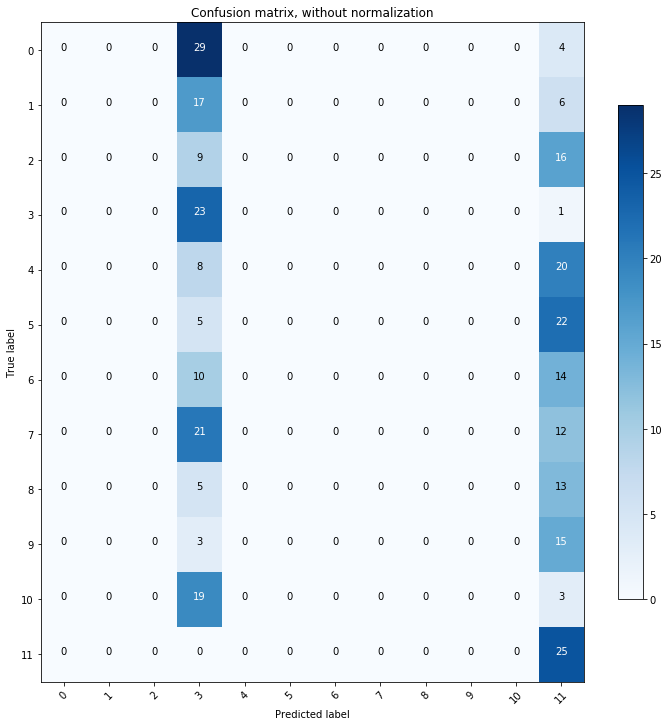

In [33]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mat, classes=np.arange(N), title='Confusion matrix, without normalization')

Classification accuracy is clearly not great. All images are classified into one of only a couple of classes


We might achieve a better accuracy by
* increasing the number of iterations (find lower plateaus)
* decreasing the learning rate
* providing more examples of each category
* using a deeper network
* uses smaller batches of training data

Most of these steps are computationally expensive in the way we've set things up. We need to use computational graphs to achieve a tractable computational speed

## Building a neural network with tensorflow

We'll do roughly the same thing, this time with tensorflow

In [34]:
import tensorflow as tf

Because graph computation is MUCH faster for ANN computations, we can decrease the learning rate and increase the number of epochs, and still execute the training in a faster time

We can also increase the number of hidden layers, from 1 to 2

We can also use smaller batches of training data sets, which allow us to prevent over-fitting and also allow us to tell how we're doing as we go

In [35]:
# Parameters
alpha = 0.01
num_steps = 15000 
batch_size = 32 
display_step = 1000

# Network Parameters
n_hidden_1 = num_neurons*2 ##1st layer number of neurons
n_hidden_2 = num_neurons*2 ## 2nd layer number of neurons
##num_input = size**2 ## for working with greyscale imagery
num_input = 3*size**2

logs_path = '/tmp/tensorflow_logs/example/'

Create placeholders for inputs (X = image data, y = labels)

In [36]:
# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, N])

Set up network weights and biases

In [37]:
# Store layers weight & bias# Store 
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, N]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([N]))
}

Create model by adding hidden layers and output layer

In [38]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with X neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with X neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [39]:
# Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=alpha)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



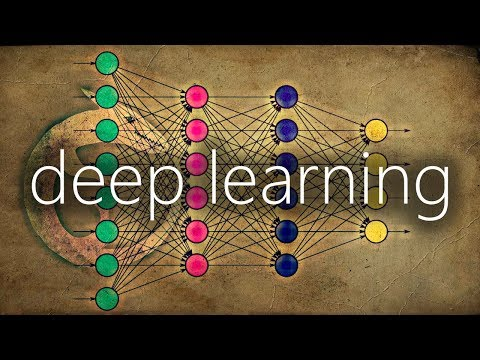

In [40]:
YouTubeVideo('U4WB9p6ODjM') ##4 mins

Train the model:

In [41]:
# Start training
A =[]
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for step in range(1, num_steps+1):
        ind = r.choice(np.arange(np.shape(X_train)[0]),batch_size)
        batch_x = X_train[ind]
        batch_y = y_v_train[ind]
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            A.append(acc)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: X_test, Y: y_v_test}))
    y_pred = sess.run(tf.argmax(logits, 1), feed_dict={X: X_test, Y: y_v_test}) 

Step 1, Minibatch Loss= 3338.0347, Training Accuracy= 0.062
Step 1000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 2000, Minibatch Loss= 2.1137, Training Accuracy= 0.938
Step 3000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 4000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 5000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 6000, Minibatch Loss= 6.9564, Training Accuracy= 0.969
Step 7000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 8000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 9000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 10000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 11000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 12000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 13000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 14000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Step 15000, Minibatch Loss= 0.0000, Training Accuracy= 1.000
Optimization Finished!
Testing Acc

Let's make a plot of training accuracy. In this case, training accuracy is much larger than testing accuracy

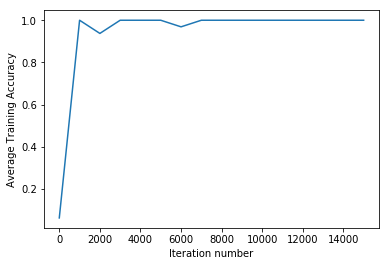

In [42]:
plt.plot(np.arange(0,num_steps+1, display_step), A)
plt.ylabel('Average Training Accuracy')
plt.xlabel('Iteration number')
plt.show()

Confusion matrix, without normalization


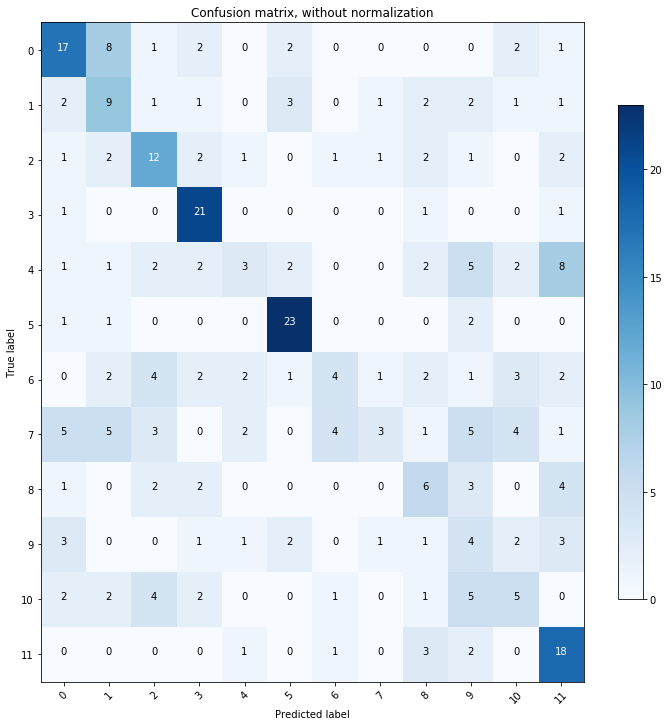

In [43]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mat, classes=np.arange(N), title='Confusion matrix, without normalization')

In machine learning, there is a phenomenon called “overfitting”. This occurs when models, during training, become too complex – they become really well adapted to predict the training data, but when they are asked to predict something based on new data that they haven’t “seen” before, they perform poorly. In other words, the models don’t generalize very well. 

Steps for reducing overfitting include:

* Add more data
* Reduce data complexity
* Use data augmentation
* Use architectures that generalize well
* Add regularization (dropout layers)
* Reduce architecture complexity.

### Backpropagation: In depth

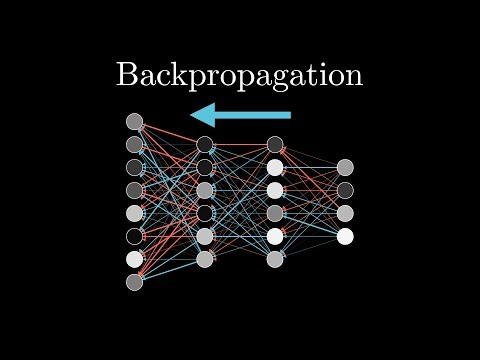

In [44]:
YouTubeVideo('Ilg3gGewQ5U')

### More videos

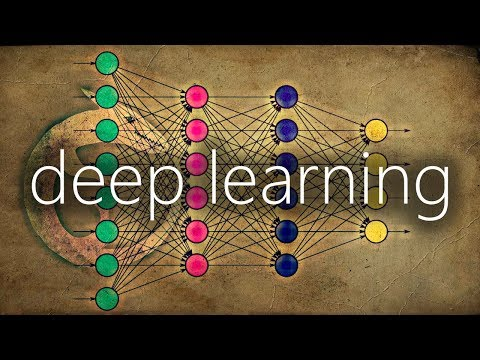

In [45]:
YouTubeVideo('jWT-AX9677k')

## Exercises

1. Compute the F1 (or other accuracy) scores for the TF ANN
2. Does feature extraction using PCA improve the accuracy of the TF ANN?

    1. Compute the F1 (or other accuracy) scores for the TF ANN

    2. Explore whether the TF ANN gives overall better accuracy if PCA feature extraction is used instead of raw images

You will need to
1. decompose the ```X_train``` data into a lower-dimensional dataset using principal components
2. Create new placeholders (```X``` and ```Y```), weights and biases
3. Construct a new ANN model
4. Train the model and examine the final test accuracy
5. Repeat steps 1 through 4 above with different numbers of principal components

What number of principal components gives the best final test accuracy?